In [52]:
import os 
import numpy as np 
import pandas as pd
import shutil
from PIL import Image
import matplotlib.pyplot as plt 
%matplotlib inline

In [53]:
import splitfolders
# Splits the dataset
splitfolders.ratio("dataset/data", output="dataset/data-splited", seed=42, ratio=(.7, .15, .15))

Copying files: 241 files [00:00, 274.93 files/s]


In [54]:
from keras.preprocessing.image import ImageDataGenerator

dir_path = "dataset/data-splited"


# Define data augmentation settings
train_datagen = ImageDataGenerator(
                                    rescale=1./255,
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    vertical_flip=False,
                                    fill_mode="constant",
                                    cval=0, #  This will fill the new pixels with black
                                )


train_set = train_datagen.flow_from_directory(
                                            os.path.join(dir_path, "train"),
                                            shuffle=True,
                                            target_size=(224, 224),
                                            batch_size=64,
                                            class_mode="sparse",
                                            )

# validation and test set
datagen = ImageDataGenerator(rescale=1./255)

val_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "val"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=64,
                                    class_mode="sparse",
                                    )

test_set = datagen.flow_from_directory(
                                    os.path.join(dir_path, "test"),
                                    shuffle=False,
                                    target_size=(224, 224),
                                    batch_size=64,
                                    class_mode="sparse",
                                    )


Found 168 images belonging to 4 classes.
Found 34 images belonging to 4 classes.


Found 39 images belonging to 4 classes.


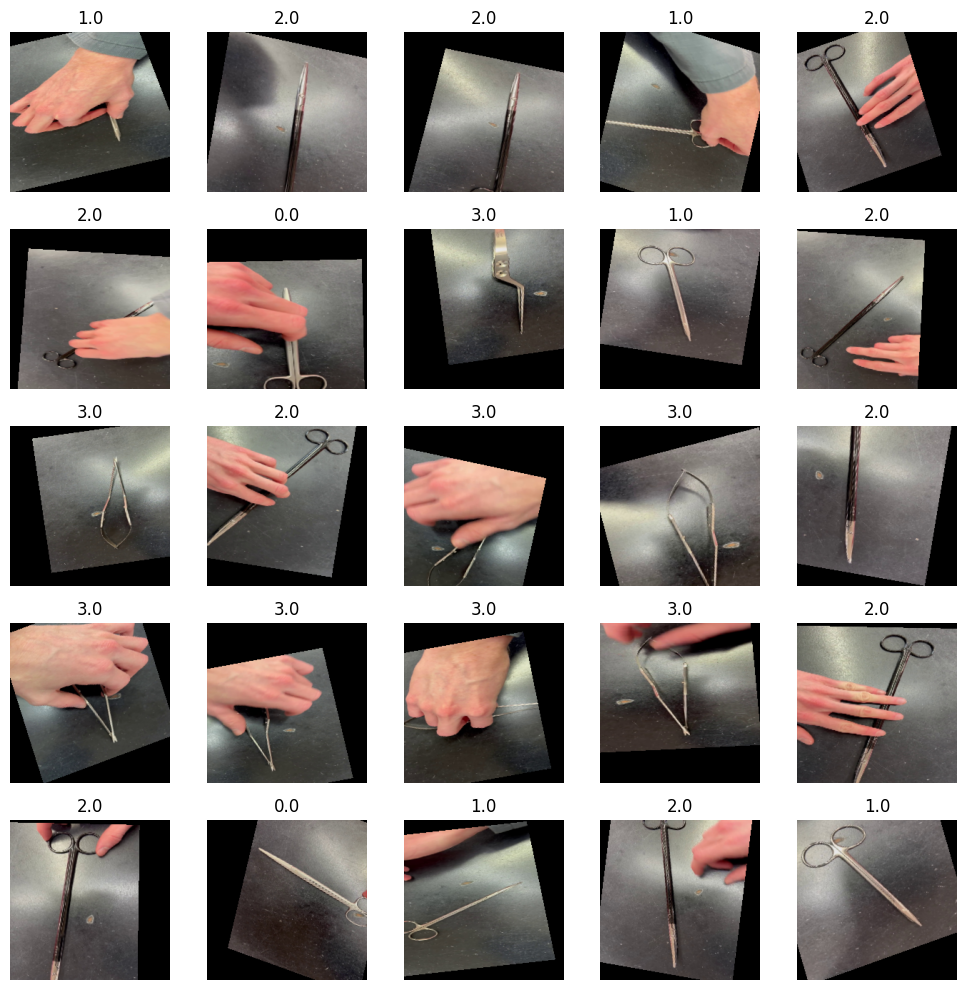

In [55]:
# Extract a batch of images and labels from train_set
images, labels = next(train_set)


# Plotting the first 25 images from the batch

img_train, label_train = next(train_set)

fig, axs =  plt.subplots(5,5, figsize=(10,10))

for i, ax in zip(range(25), axs.ravel()):
    ax.imshow(img_train[i])
    ax.axis('off')
    ax.set_title(label_train[i])
plt.tight_layout()
plt.show()

C:\Users\louis\AppData\Local\Temp\ipykernel_11852\826677915.py:11: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  proportion = pd.value_counts(name.classes, normalize=False, sort=False)


Mean proportion of images in train set: 42
Mean proportion of images in validation set: 8
Mean proportion of images in test set: 10


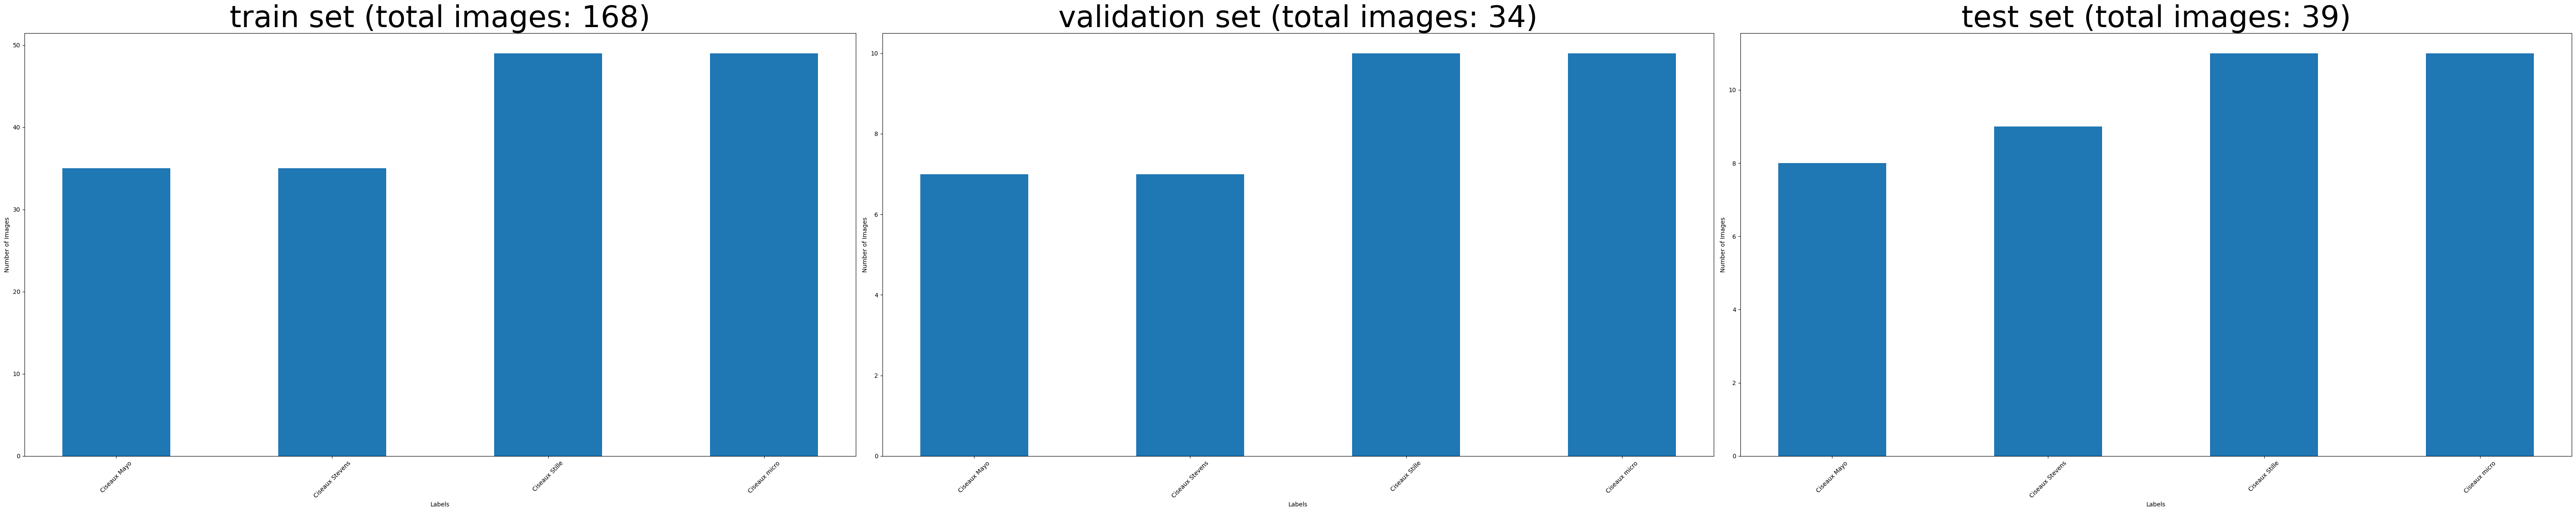

In [56]:
# Setup set names
set_names = ["train set", "validation set", "test set"]
categories = train_set.class_indices.keys()

# Plot
fig, axes = plt.subplots(1, 3, figsize=(60, 12))

for set_name, name, ax in zip(set_names, [train_set, val_set, test_set], axes.ravel()):

    # Get the count of each label in the train set
    proportion = pd.value_counts(name.classes, normalize=False, sort=False)
    print("Mean proportion of images in {}: {:.0f}".format(set_name, proportion.mean()))
    
    ax.bar(categories, proportion, width=0.5)
    ax.set_title(f"{set_name} (total images: {len(name.classes)})", fontsize=50)
    ax.set(
        xlabel="Labels",
        ylabel="Number of Images",
    )
    ax.tick_params(axis='x', rotation=45)
    
plt.tight_layout()
plt.show()

In [66]:
import tensorflow.keras as keras
from tensorflow.keras.applications import MobileNetV3Small


# Load the pretrained model
base_model =  MobileNetV3Large(input_shape=(224, 224, 3), weights="imagenet", include_top=False, include_preprocessing=False)

# Make layers of the base model trainable
base_model.trainable = False

# Get the number of layers for the base_model
print(f"The base_model has {len(base_model.layers)} layers.")

# Unfreeze the last few layers for fine-tuning
fine_tune_at = 255

# Freezes the weights of the pre-train model
""" for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True """


# Creat a new classification layers on top
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
""" x = keras.layers.Dropout(0.2)(x) """
x = keras.layers.Dense(1024, activation="relu")(x)
""" x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.Dense(512, activation="relu")(x) """
outputs = keras.layers.Dense(train_set.num_classes, activation="softmax")(x)

# Define the model
model = keras.Model(inputs=base_model.input, outputs=outputs)


# Compile the model
model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])

# Print network summary
model.summary()

The base_model has 262 layers.
Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['input_15[0][0]']               
                                )                                                                 
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 112, 112, 16  64         ['Conv[0][0]']                   
 tion)                          )                           

In [67]:
### Code to train the model

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

# End trainging whe accuracy stops improving
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# Reduce learning rate if val_loss doesn't improve
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1,
                              patience=3, min_lr=1e-10)

# Define model checkpoint
checkpoint = ModelCheckpoint("save-model.h5", monitor="val_loss", verbose=1, save_best_only=True, mode="min")

# Fit model
history = model.fit(
    train_set,
    validation_data=val_set,
    epochs=200,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1,
    workers=1, # Number of workers Depend on your configuration
)

Epoch 1/200
3/3 [==============================] - ETA: 0s - loss: 2.2609 - acc: 0.3571
Epoch 1: val_loss improved from inf to 1.81170, saving model to save-model.h5
3/3 [==============================] - 8s 2s/step - loss: 2.2609 - acc: 0.3571 - val_loss: 1.8117 - val_acc: 0.5882 - lr: 0.0010
Epoch 2/200
3/3 [==============================] - ETA: 0s - loss: 1.2470 - acc: 0.6845
Epoch 2: val_loss improved from 1.81170 to 0.62727, saving model to save-model.h5
3/3 [==============================] - 3s 817ms/step - loss: 1.2470 - acc: 0.6845 - val_loss: 0.6273 - val_acc: 0.7059 - lr: 0.0010
Epoch 3/200
3/3 [==============================] - ETA: 0s - loss: 0.6487 - acc: 0.6964
Epoch 3: val_loss improved from 0.62727 to 0.31561, saving model to save-model.h5
3/3 [==============================] - 3s 894ms/step - loss: 0.6487 - acc: 0.6964 - val_loss: 0.3156 - val_acc: 0.8824 - lr: 0.0010
Epoch 4/200
3/3 [==============================] - ETA: 0s - loss: 0.3001 - acc: 0.8869
Epoch 4: val_

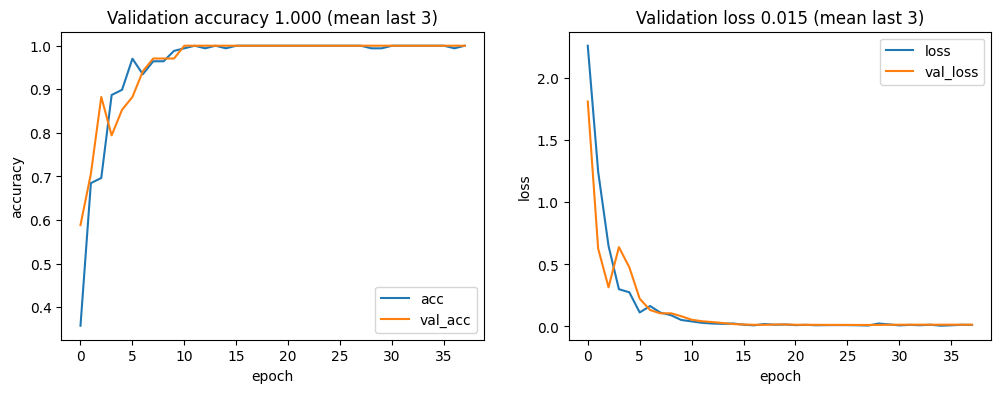

In [68]:
# Plots neural network performance metrics for train and validation
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Get the performance metrics
results = pd.DataFrame(history.history)

# Plot accuracy curves
results[["acc", "val_acc"]].plot(ax=ax1)
ax1.set_title(
    "Validation accuracy {:.3f} (mean last 3)".format(
        np.mean(results["val_acc"][-3:]) # Last three values
    )
)
ax1.set_xlabel("epoch")
ax1.set_ylabel("accuracy")

# Plot loss curves
results[["loss", "val_loss"]].plot(ax=ax2)
ax2.set_title(
    "Validation loss {:.3f} (mean last 3)".format(
        np.mean(results["val_loss"][-3:]) # Last three values
    )
)
ax2.set_xlabel("epoch")
ax2.set_ylabel("loss")

plt.show()

In [69]:
# Compute score on the test set
(test_loss, test_accuracy) = model.evaluate(test_set)

print("Test loss: {:.2f}".format(test_loss))
print("Test accuracy: {:.2%}".format(test_accuracy))

1/1 [==============================] - 0s 367ms/step - loss: 0.0470 - acc: 0.9744
Test loss: 0.05
Test accuracy: 97.44%


In [61]:
model.save("model.h5")

# To do check dataset and see if images are not good. try to have 100% accuray 